In [1]:
%matplotlib inline

# What is torch.nn really?

PyTorch提供了一个非常优美的模块和类，比如torch.nn,torch.optim,Dataset和DataLoader，他们帮助我们创建和训练神经网络。为了更好地使用他们的力量和针对我们的问题定制化模块，你需要精确理解他们在做什么。为了帮助我们理解，我们首先不用任何的pytorch Module，只用基本的Tensor操作训练一个基本的神经网络，用于识别MNIST数据集。然后我们逐步增加torch.nn,torch.optim,Dataset和DataLoader。通过这样的方式精确地展示每个部分是怎么工作的，以及如何让我们的代码更加简练、更加灵活。

**这个教程假设你安装好了pytorch，并对相关操作有基本的了解。**

## MNIST data setup

我们要使用基本的MNIST数据集，它由黑白的手写数字组成。

我们将使用pathlib解决路径问题，使用request来下载数据集。我们将仅仅在使用模块时import，所以你能精准的看到什么时候我们使用了哪个模块。

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

这个数据集是numpy数组的格式。他们已经使用pickle存储——这是一种python内的序列化数据的模块。

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每个图像都是28x28，它被保存为行为784的向量。因此想要展示图像，我们需要把它reshape为28x28.

(50000, 784)
(50000,)


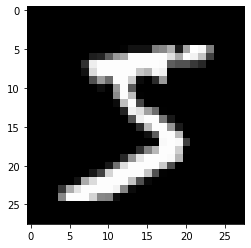

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(y_train.shape)

PyTorch使用torch.tensor而不是numpy array，所以我们需要转化数据格式。

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Neural net from scratch (no torch.nn)

首先创建一个只用tensor运算的模型。

PyTorch提供随机或初始为零的创建tensor方法，我们要用它为我们的神经网络来创建w和b。它们只是基本的tensor，我们还需要添加梯度属性，这会让pytorch在计算时记录这些运算，这样在反向传播时就可以自动地求导。

对于w和b，我们设置requires_grad=True。

In [6]:
import math

w = torch.randn(784, 10) / math.sqrt(784)
w.requires_grad_(True)
b = torch.zeros(10, requires_grad=True)

因为pytorch具有自动计算梯度的能力，我们能使用任意的标准python函数作为model。因此我们写一个基本的矩阵乘法和广播加法来创建简单的线性模块。我们还需要激活函数，所以我们写一个log_softmax。

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb@w+b)


上面的@是矩阵乘法。我们会在forward函数里调用上面的函数。在这个阶段，我们的预测结果不会比随机猜好多少，因为w和b都是随机的。

In [8]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-2.2140, -2.5716, -2.1541, -2.5556, -2.9169, -2.3731, -2.0009, -1.8493,
         -2.2918, -2.5290], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

正如我们看到的，preds不仅包括值，还包括梯度函数，我们将在反向传播时使用到这个。

接下来我们实现负的log似然函数作为loss function。

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

我们使用当前这个随机模型的输出来验证一下loss的功能，通过对比，我们能看到loss在变小。

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3848, grad_fn=<NegBackward>)


下面的函数用于计算模型的准确率。对于每次预测，我们选择值最大的那个索引作为预测结果。

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

看一下在随机模型下的准确率：

In [12]:
print(accuracy(preds, yb))

tensor(0.1094)


我们能运行训练循环了。对于每个迭代，我们要做：
- 选择一个数据的mini-batch
- 使用模型去预测结果
- 计算loss
- loss.backward()更新模型中参数的梯度，在这个案例中，是w和b

更新参数的过程要在torch.no_grad()下，因为我们不希望在反向传播时保存梯度信息。

然后要记得把梯度清零，这样才能开始下一轮的训练。因为loss.backward()会叠加梯度而不是替换。

In [17]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        print(loss.item(), accuracy(pred, yb))
        loss.backward()
        with torch.no_grad():
            w -= w.grad * lr
            b -= b.grad * lr
            w.grad.zero_()
            b.grad.zero_()
        

0.19133776426315308 tensor(0.9531)
0.1927119642496109 tensor(0.9844)
0.37512335181236267 tensor(0.9062)
0.30613717436790466 tensor(0.8906)
0.3707409203052521 tensor(0.8750)
0.07918106019496918 tensor(0.9688)
0.17526431381702423 tensor(0.9219)
0.43739959597587585 tensor(0.9062)
0.17044353485107422 tensor(0.9375)
0.34060826897621155 tensor(0.9219)
0.317685604095459 tensor(0.9531)
0.18646810948848724 tensor(0.9375)
0.2737189829349518 tensor(0.9062)
0.5141398906707764 tensor(0.8594)
0.4013713300228119 tensor(0.8906)
0.2668895423412323 tensor(0.9219)
0.6238927841186523 tensor(0.8438)
0.6400451064109802 tensor(0.7812)
0.07718885689973831 tensor(0.9688)
0.5690637826919556 tensor(0.8750)
0.3439263701438904 tensor(0.8906)
0.6506285071372986 tensor(0.8594)
0.220356747508049 tensor(0.9062)
0.28316807746887207 tensor(0.8906)
0.30555403232574463 tensor(0.9062)
0.14686985313892365 tensor(0.9688)
0.16125500202178955 tensor(0.9688)
0.1654016375541687 tensor(0.9531)
0.22721987962722778 tensor(0.9531)
0

0.13760054111480713 tensor(0.9375)
0.2374996542930603 tensor(0.9219)
0.28263261914253235 tensor(0.8906)
0.2933351695537567 tensor(0.8906)
0.15938973426818848 tensor(0.9688)
0.49057066440582275 tensor(0.8594)
0.17424814403057098 tensor(0.9375)
0.2513473331928253 tensor(0.9531)
0.1290832757949829 tensor(0.9531)
0.15452763438224792 tensor(0.9375)
0.16074267029762268 tensor(0.9531)
0.3608434796333313 tensor(0.9062)
0.2567233145236969 tensor(0.9375)
0.541446328163147 tensor(0.9219)
0.3577418327331543 tensor(0.9062)
0.3942852020263672 tensor(0.9219)
0.6241058111190796 tensor(0.8750)
0.6544413566589355 tensor(0.8594)
0.3775171935558319 tensor(0.9062)
0.3589111566543579 tensor(0.9375)
0.2578904330730438 tensor(0.9688)
0.2536904811859131 tensor(0.9219)
0.1435662806034088 tensor(0.9688)
0.27738744020462036 tensor(0.9375)
0.2630101442337036 tensor(0.9375)
0.08520247042179108 tensor(0.9688)
0.18586769700050354 tensor(0.9531)
0.49383026361465454 tensor(0.8906)
0.24958890676498413 tensor(0.9219)
0.2

0.40394705533981323 tensor(0.8750)
0.4632372260093689 tensor(0.8750)
0.2459852546453476 tensor(0.9375)
0.17709098756313324 tensor(0.9375)
0.28903186321258545 tensor(0.9219)
0.2390616536140442 tensor(0.9688)
0.29209211468696594 tensor(0.8750)
0.19383063912391663 tensor(0.9531)
0.21446886658668518 tensor(0.9531)
0.42747190594673157 tensor(0.9062)
0.1827058494091034 tensor(0.9219)
0.33314478397369385 tensor(0.8906)
0.24160519242286682 tensor(0.9062)
0.14492271840572357 tensor(0.9688)
0.2631601393222809 tensor(0.9062)
0.283083975315094 tensor(0.9219)
0.167182058095932 tensor(0.9688)
0.34534966945648193 tensor(0.8906)
0.28744009137153625 tensor(0.9062)
0.24376174807548523 tensor(0.9062)
0.2426968812942505 tensor(0.9375)
0.35960057377815247 tensor(0.9375)
0.15708842873573303 tensor(0.9375)
0.17667913436889648 tensor(0.9531)
0.18972060084342957 tensor(0.9531)
0.4765377640724182 tensor(0.8438)
0.2460229992866516 tensor(0.9375)
0.25818488001823425 tensor(0.9219)
0.22892791032791138 tensor(0.921

0.21250559389591217 tensor(0.9219)
0.5360432863235474 tensor(0.8750)
0.20031480491161346 tensor(0.9375)
0.2882480025291443 tensor(0.9219)
0.2600603997707367 tensor(0.9375)
0.2260739505290985 tensor(0.9375)
0.07087791711091995 tensor(0.9844)
0.3380078673362732 tensor(0.9062)
0.17646007239818573 tensor(0.9219)
0.32406169176101685 tensor(0.9062)
0.24555949866771698 tensor(0.9219)
0.22270600497722626 tensor(0.9062)
0.33889755606651306 tensor(0.9375)
0.2837350070476532 tensor(0.9219)
0.20154744386672974 tensor(0.9688)
0.1670442372560501 tensor(0.9531)
0.32707107067108154 tensor(0.9219)
0.09167852252721786 tensor(0.9844)
0.1823389083147049 tensor(0.9531)
0.0840853899717331 tensor(1.)
0.11664815992116928 tensor(0.9688)
0.26254695653915405 tensor(0.9219)
0.3134908080101013 tensor(0.9219)
0.13824008405208588 tensor(0.9375)
0.1799473613500595 tensor(0.9531)
0.1738457977771759 tensor(0.9531)
0.14308342337608337 tensor(0.9531)
0.35641416907310486 tensor(0.8750)
0.4478415548801422 tensor(0.9062)
0.

0.6227921843528748 tensor(0.8750)
0.6430667638778687 tensor(0.8594)
0.3726019263267517 tensor(0.9062)
0.35584786534309387 tensor(0.9375)
0.25103527307510376 tensor(0.9688)
0.24773955345153809 tensor(0.9219)
0.14220617711544037 tensor(0.9688)
0.27566584944725037 tensor(0.9219)
0.2589729428291321 tensor(0.9375)
0.08486108481884003 tensor(0.9688)
0.18121382594108582 tensor(0.9531)
0.4890833795070648 tensor(0.8906)
0.24478769302368164 tensor(0.9219)
0.23462143540382385 tensor(0.9375)
0.07113039493560791 tensor(1.)
0.07848846912384033 tensor(0.9844)
0.2308158129453659 tensor(0.9062)
0.32970213890075684 tensor(0.9375)
0.08422369509935379 tensor(0.9844)
0.2909955084323883 tensor(0.9219)
0.3838285207748413 tensor(0.8906)
0.5017582774162292 tensor(0.9375)
0.2560933828353882 tensor(0.9375)
0.059464164078235626 tensor(1.)
0.23425611853599548 tensor(0.9219)
0.4368111789226532 tensor(0.8906)
0.5858156085014343 tensor(0.8125)
0.40578770637512207 tensor(0.8906)
0.1950586885213852 tensor(0.9688)
0.178

0.3293892741203308 tensor(0.8906)
0.23576147854328156 tensor(0.9062)
0.14227880537509918 tensor(0.9688)
0.26062148809432983 tensor(0.9062)
0.2831616699695587 tensor(0.9219)
0.16247409582138062 tensor(0.9688)
0.3400288224220276 tensor(0.8906)
0.2824164628982544 tensor(0.9062)
0.23890364170074463 tensor(0.9062)
0.2371377944946289 tensor(0.9375)
0.35533809661865234 tensor(0.9375)
0.1547004133462906 tensor(0.9375)
0.17498676478862762 tensor(0.9531)
0.18756011128425598 tensor(0.9531)
0.4759255647659302 tensor(0.8594)
0.24561145901679993 tensor(0.9375)
0.2552059292793274 tensor(0.9219)
0.2267967015504837 tensor(0.9219)
0.31477808952331543 tensor(0.9062)
0.4832991361618042 tensor(0.8594)
0.2853761911392212 tensor(0.8594)
0.5951343774795532 tensor(0.8750)
0.34996169805526733 tensor(0.9062)
0.3562711179256439 tensor(0.8906)
0.170293927192688 tensor(0.9219)
0.17220252752304077 tensor(0.9375)
0.2380416989326477 tensor(0.9531)
0.2005981206893921 tensor(0.9219)
0.17693860828876495 tensor(0.9375)
0.

In [19]:
r = 1000
print(loss_func(model(x_train[r:r+bs]), y_train[r:r+bs]), accuracy(model(x_train[r:r+bs]), y_train[r:r+bs]))

tensor(0.4005, grad_fn=<NegBackward>) tensor(0.8594)


## Using torch.nn.functional

我们要重构代码，功能不需要变化，仅仅是要使用torch.nn来让代码更简洁更灵活。接下来的每一步我们都要让代码变得更短更容易理解更灵活。

第一件也是最简单的步骤是把我们手写的激活函数和损失函数替换为torch.nn.functional(通常取别名为F)。这个模块包含了torch.nn中的所有函数。包括许多损失函数和激活函数，你也能在这里找到用于构建神经网络的函数，包括池化函数。（它也包含一些卷积、全连接函数等操作，但我们将会看到，在其他库中有更好的选择）

如果你使用负对数似然函数损失和softmax激活函数，那么pytorch提供了F.cross_entropy。

In [20]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ w + b

我们来验证一下，这个函数与我们之前手写的有什么不同。

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0605, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

接下来，我们使用nn.Moduel and nn.Parameter，目的是得到一个更清晰更简单的训练过程。我们继承nn.Module。在这个例子中，我们想创建一个类来保存w和b，和forward函数。nn.Module有许多属性和方法可以派上用场。（比如.parameters()， .zero_grad()）

In [22]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.b = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.w + self.b

既然我们已经使用一个对象来替换函数，我们首先要创建一个类的实例。

In [23]:
model = Mnist_Logistic()

现在我们可以使用跟之前一样的方法来计算loss。看起来nn.Module是一个方法，但实际上，它调用了类内部的forward函数。

In [27]:
print(loss_func(model(xb), yb))

tensor(2.5355, grad_fn=<NllLossBackward>)


在这之前，我们必须在训练时按照参数名字更新权重，手动地把梯度清零，像这样：

In [29]:
with torch.no_grad():
    w -= w * lr
    b -= b.grad * lr
    w.grad.zero_()
    b.grad.zero_()

现在，我们可以利用model.parameters()和model.zero_grad()去让这些步骤更简单而且更不容易忘记一些参数。尤其是我们有一个很复杂的模型。

In [36]:
# 这个run不了，还没有梯度
# with torch.no_grad():
#     for p in model.parameters(): 
#         p -= p.grad * lr
#     model.zero_grad()

我们把这些函数包装到一个函数里。

In [37]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

检查一下结果。

In [39]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)
tensor(1.)


## Refactor using nn.Linear

接下来我们继续重构代码。我们不再手动定义w和b，手动计算xb @ self.w + self.b，而是使用nn.Linear作为一个layer。nn中还有许多定义好的layer使用它们可以简化我们的代码，而且通常会使代码跑的更快。

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

实例化一个model并且用同样的方式计算loss。

In [41]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3289, grad_fn=<NllLossBackward>)


我们仍然能够适合fit()

In [42]:
fit()
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)
tensor(1.)


## Refactor using optim

torch.optim里包含许多优化算法。我们能使用step函数代替手动更新参数的过程。

这让我们可以把以前的优化部分代码

In [43]:
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()

替换为：

In [44]:
# opt.step()
# opt.zero_grad()

optim.zero_grad()将梯度置为零，我们需要在下一个batch重新计算梯度之前调用这个方法。

In [45]:
from torch import optim

我们把能用得上的代码包装一下，避免我们重复书写。

In [47]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb).item(), accuracy(model(xb), yb).item())

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb).item(), accuracy(model(xb), yb).item())

2.3354597091674805 0.125
0.08091235905885696 1.0


## Refactor using Dataset

pytorch有一个抽象类——Dataset。Dataset可以是任何东西，只要他有__len__函数和__getitem__函数。

PyTorch的TensorDataset是一个包装了tensor的Dataset。通过定义一个length和一个索引的方式，这也就给我们一个在第一维迭代、索引、切片的方式。这让我们在一行访问独立和非独立的变量变成可能。

In [48]:
from torch.utils.data import TensorDataset

x_train 和 y_train都能使用TensorDataset来绑定在一起，这让迭代和切片更容易。

In [49]:
train_ds = TensorDataset(x_train, y_train)

之前，我们不得不分别迭代获取x和y的值：

In [50]:
#xb = x_train[start_i:end_i]
#yb = y_train[start_i:end_i]


现在，我们能把这两步放在一起：

In [51]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [52]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb).item(), accuracy(model(xb), yb).item())

0.08135267347097397 1.0


## Refactor using DataLoader

PyTorch的``DataLoader``负责管理batch。你可以从任意一个DataSet创建一个DataLoader。DataLoader让遍历变得更简单。这样我们就不必每次都用``train_ds\[i*bs : i*bs+bs\]``这种方式，DataLoader会自动地为我们提供mini-batch。

In [53]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

之前我们的循环长这样：

In [54]:
# for i in range((n-1)//bs + 1):
#     xb,yb = train_ds[i*bs : i*bs+bs]
#     pred = model(xb)

现在，我们的循环变得更加简洁，（xb，yb）被dataloader自动地装载。

In [55]:
# for xb, yb in train_d1:
#     pred = model(xb)

In [59]:
model, opt = get_model()

for epoch in range(epochs):
    for i, (xb, yb) in enumerate(train_dl):
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb).item(), accuracy(model(xb), yb).item())

0.08171205967664719 1.0


因为PyTorch的nn.Module,nn.Parameter,Dataset和Dataloader，我们的训练过程才可以这么简洁这么易于理解。现在让我们尝试添加一些必要的feature来让我们的模型在实际中更有效率。

## Add validation

在第一部分，我们在努力把训练部分的代码变得合理变得简洁。事实上，我们还需要一个验证集，用来证明我们训练的模型是否过拟合。

把训练数据打乱是很重要的，这能减少batch之间的相关性并且避免过拟合。另一方面，验证集是否打乱对于验证集的loss没有影响。既然打乱需要额外的时间消耗，那么打乱验证集是没有意义的。

我们将会在验证集上使用二倍于训练集的batchsize。这是因为，验证集上的计算不需要反向传播，因此也就不需要担心因存储梯度而带来的内存消耗。我们可以充分利用这一点，使用更大的batchsize来加速运算。

In [60]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size= bs * 2)

我们需要在每个循环打印验证集的loss。
注意model.train()和model.eval()

In [66]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)
    
    print(epoch, valid_loss.item() / len(valid_dl), valid_acc.item() / len(valid_dl))

0 0.29914346525940716 0.9139636075949367
1 0.27666164349906053 0.9236550632911392


## Create fit() and get_data()

现在我们做一点自己的重构。既然我们要为训练集和验证集计算两次loss，那么不如把他们封装在一起。

在训练时，我们需要使用优化器优化，但验证时不需要。

In [67]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

fit运行必要的操作去训练我们的模型，并且计算每个epoch训练集和验证集的loss。

In [68]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

get_data返回训练集和测试集的dataloader。

In [70]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

现在，我们获取数据和训练模型的代码只需要这三行

In [71]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2947019842028618
1 0.2878762198805809


## Switch to CNN

现在我们要在神经网络中加一些卷积层。因为在之前的网络中我们没有对数据格式做任何要求，因此我们能够不加任何改变把它们应用在卷积神经网络中。

我们直接使用Pytorch的Conv2d类作为卷积层。我们定义一个带有三个卷积层的CNN。每个卷积后面都跟着一个ReLU。最后我们用一个平均池化。

In [79]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)#14
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)#7
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)#4
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb = xb.view(-1, xb.size(1))
        return xb

lr = 0.1

动量是一个SGD的参数，它引入了以前的梯度更新信息，能使训练变得更快。

In [80]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3334541584253311
1 0.24303401448726655


## nn.Sequential

torch.nn还有一个好用的类，我们可以用来简化代码——Sequential。一个Sequential对象运行每个被包含在里面的Module。这是一个更简单地书写神经网络地方法。

为了充分利用这一优势，我们需要能够从一个给定的函数构建我们自己的layer。Lambda将会帮我们创建一个layer，这将在之后用Sequential定义网络时起作用。

In [81]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

上小节的CNN可以使用Sequential这样定义：

In [84]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x : x.view(-1, x.size(1))),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)
print(loss_func(model(x_valid), y_valid).item(), accuracy(model(x_valid), y_valid).item())

0 0.3226627793312073
1 0.2517242193937302
0.2517232298851013 0.9296000003814697


## Wrapping DataLoader

我们的CNN已经相当简洁了，但是它仅仅能用于MNIST数据集，因为：
- 它假设输入是28x28
- 它假设最终的卷积输出是4x4

现在我们抛弃这两个假设，我们的模型可以处理任意二维的单通道图像。首先我们移除Lambda layer，把数据预处理放进一个生成器。

In [85]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

接下来我们用nn.AdaptiveAvgPool2d替换nn.AvgPool2d。它能允许我们定义想要的输出，而不是只能根据输入去计算。因此我们的模型可以处理任何尺寸。

In [87]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [90]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.17400281445980073
1 0.1647987748682499


## Using your GPU

如果你有支持CUDA的GPU，那么你就可以使用硬件加速计算。首先检查有没有CUDA：

In [91]:
print(torch.cuda.is_available())

True


然后创建一个device对象：

In [92]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

更新preprocess函数，把tensor移动到GPU：

In [93]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

最后，把模型移动到GPU：

In [94]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

感受一下速度吧：

In [95]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.14535682306289674
1 0.13263009257316588


## Closing thoughts

我们已经完成了一个通用的数据处理和模型训练过程，这些经历能帮助你训练其他类型的model。如果想弄清楚这个简单的模型是怎样工作的，我们可以看看mnist_sample这个notebook。

当然，那还有许多事情我们可以加进来，比如数据增广，超参数调参，监控训练，迁移学习等。

我们在文章的一开始就承诺我们会通过例子解释torch.nn,torch.optim,Dataset和Dataloader。现在我们来总结一下：

- **torch.nn**
    + ``Module``：一个可调用对象，用起来像一个函数，但它是一个类能存储属性（例如各种参数）。它能管理它的参数，比如更新梯度，清零梯度，遍历参数等等。
    + ``Parameter``：一个tensor的包装器，可以保存梯度信息，但需要requires_grad=True。
    + ``functional``：这个模块包括各种激活函数，损失函数等。还包括无状态的layer函数。比如卷积、全连接。
- ``torch.optim``：包含各种优化器。
- ``Dataset``：一个带有__len__和__getitem__的抽象接口。
- ``DataLoader``：获取一个Dataset，创建一个可迭代的对象。每次返回一个batch的数据。